In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_error
from pytorch_tcn import TCN
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import csv
from torchsummary import summary
from scipy.stats import gaussian_kde
from copy import deepcopy
import random
from torch.autograd import Variable

In [33]:
class FishCountPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_chanellsOut):
        super(FishCountPredictor, self).__init__()
        self.tcn = TCN(num_inputs, num_channels, causal=True
                      , use_norm = 'batch_norm'
                       , dropout = 0.2
                      )
        #self.avgPool = nn.AvgPool2d(kernel_size = (num_chanellsOut, 407))
        #self.avgPool = nn.MaxPool2d(kernel_size = (num_chanellsOut, 407))
        #self.avgPool = nn.MaxPool1d(kernel_size = 708)
        self.avgPool = nn.AvgPool1d(kernel_size = 709) #Avg can be replace by Max but it slightly underperforms
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Assuming x has shape (batch_size, input_size, sequence_length)
        out = self.tcn(x) # Output: (num_chanellsOut, 407)
        #print(out)
        out = self.avgPool(out) # Output: 1, num_chanellsOut
        #print(out)
        out = self.flatten(out) # Output: num_chanellsOut
        #print(out)
        out = self.fc(out) # Output: 1
        #print(out)
        return out
        
# Define your dataset class
class FishDataset(Dataset):
    def __init__(self, sequences, targets, species):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
        self.species = torch.tensor(species, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx], self.species[idx]


# Define the weighted loss
#If target == 0, no change, if target > 0 increase the weight of the loss
def weighted_mse_loss(input, target, weights):
    get_0 = (target != 0).float()
    get_0[get_0==0] = 0.2 #80/20 is the rough ratio of 0s and more occurence videos

    error = ((input - target) ** 2)*weights
    error = error * get_0 
    
    return error

#Evaluate per Class!
def evaluate_model(model, dataloader):
    model.eval()
    
    total_loss_s0 = 0.0
    total_loss_s1 = 0.0
    total_loss_s2 = 0.0
    total_samples_s0 = 0
    total_samples_s1 = 0
    total_samples_s2 = 0

    with torch.no_grad():
        for sequences, targets, species in dataloader:
            species_ID = species

            batchSize = sequences.shape[0]
            sequences = sequences.reshape(batchSize, 1, 709)
            output = model(sequences)

            # Do the multi head output with a mask for the species not involved and use only the species needed
            mask_s0 = (species_ID == 13).float()
            mask_s1 = (species_ID == 17).float()
            mask_s2 = (species_ID == 1).float()

            output_s0 = mask_s0 * output[:, 0]
            output_s1 = mask_s1 * output[:, 1]
            output_s2 = mask_s2 * output[:, 2]

            # Change the targets as well (split per species)
            targets_s0 = mask_s0 * (targets[:, 0] + targets[:, 1] + targets[:, 2]).float()
            targets_s1 = mask_s1 * (targets[:, 0] + targets[:, 1] + targets[:, 2]).float()
            targets_s2 = mask_s2 * (targets[:, 0] + targets[:, 1] + targets[:, 2]).float()

            # Get the weights for the weighted loss
            weights_s0 = mask_s0 * 1
            weights_s1 = mask_s1 * 1
            weights_s2 = mask_s2 * 1

            # Calculate the loss per species (masked by species)
            loss_s0 = weighted_mse_loss(output_s0, targets_s0, weights=weights_s0).mean().item()
            loss_s1 = weighted_mse_loss(output_s1, targets_s1, weights=weights_s1).mean().item()
            loss_s2 = weighted_mse_loss(output_s2, targets_s2, weights=weights_s2).mean().item()

            # Accumulate the loss per class
            total_loss_s0 += loss_s0 * mask_s0.sum().item()
            total_loss_s1 += loss_s1 * mask_s1.sum().item()
            total_loss_s2 += loss_s2 * mask_s2.sum().item()

            # Track the number of samples per class
            total_samples_s0 += mask_s0.sum().item()
            total_samples_s1 += mask_s1.sum().item()
            total_samples_s2 += mask_s2.sum().item()

    # Compute the average loss per class
    avg_loss_s0 = total_loss_s0 / (total_samples_s0 + 1e-8) if total_samples_s0 > 0 else 0
    avg_loss_s1 = total_loss_s1 / (total_samples_s1 + 1e-8) if total_samples_s1 > 0 else 0
    avg_loss_s2 = total_loss_s2 / (total_samples_s2 + 1e-8) if total_samples_s2 > 0 else 0

    # Optionally return the losses for each class
    return avg_loss_s0, avg_loss_s1, avg_loss_s2


def train_model(model, dataloader, optimizer, lr_after_decay, epoch_delay, num_epochs, dataloaderVal):
    model.train()
    loss_list = []
    
    # Validation loss lists for each class
    val_loss_s0_list = []
    val_loss_s1_list = []
    val_loss_s2_list = []

    for epoch in range(num_epochs):

        if epoch > epoch_delay:     
            # Manual learning rate decay
            for g in optimizer.param_groups:
                g['lr'] = lr_after_decay
                
        for sequences, targets, species in dataloader:
            species_ID = species
            
            batchSize = sequences.shape[0]
            sequences = sequences.reshape(batchSize, 1, 709)
            
            optimizer.zero_grad()
            output = model(sequences)

            # Masked outputs
            mask_s0 = (species_ID == 13).float()
            mask_s1 = (species_ID == 17).float()
            mask_s2 = (species_ID == 1).float()
         
            output = mask_s0 * output[:, 0] + mask_s1 * output[:, 1] + mask_s2 * output[:, 2]

            # Change the targets as well
            targets = targets.float()
            targets = targets[:, 0] + targets[:, 1] + targets[:, 2]

            # Get the weights for the weighted loss
            weights = mask_s0 * 1 + mask_s1 * 1 + mask_s2 * 1

            loss = weighted_mse_loss(output, targets, weights=weights)
            loss.mean().backward()
            optimizer.step()

        loss_list.append(loss.mean().item())  
        
        # Unpack the val_loss tuple into individual species losses
        val_loss_s0, val_loss_s1, val_loss_s2 = evaluate_model(model, dataloaderVal)
        val_loss_s0_list.append(val_loss_s0)
        val_loss_s1_list.append(val_loss_s1)
        val_loss_s2_list.append(val_loss_s2)
        
    # Plotting Training Loss and Validation Losses per Class
    plt.figure(figsize=(12, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_list, label="Training Loss")
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot validation loss per class
    plt.subplot(1, 2, 2)
    plt.plot(val_loss_s0_list, label='Class 13 Validation Loss')
    plt.plot(val_loss_s1_list, label='Class 17 Validation Loss')
    plt.plot(val_loss_s2_list, label='Class 1 Validation Loss')
    plt.title('Validation Loss per Class')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def contains_positive_number(x):
    return pd.notnull(x) and isinstance(x, (int, float)) and x > 0

In [34]:
# Define your data
#Without the train detections included
dataset = pd.read_csv('./04_Datasets/boundingboxes_joined_3heads_fullayAuto.csv')

#With the train detections included
dataset.fillna(0, inplace=True)

#If we want to split the dataset in predefined train / test
#I went for this to have the same conditions for all methods (Nmax, Nimproved, etc.)
dataset_Train = dataset[dataset["category"] == 'train']
dataset_Test = dataset[dataset["category"] == 'test']

#Define the train set
sequences_Train = dataset_Train.iloc[:, 6:].values.tolist() # List of sequences of fish counts
targets_Train = dataset_Train.iloc[:, 2:5].values.tolist()   # List of corresponding overall number of fish
species_Train = dataset_Train.iloc[:, 5:6].values.tolist()

#Define the test set
sequences_Test = dataset_Test.iloc[:, 6:].values.tolist() # List of sequences of fish counts
targets_Test = dataset_Test.iloc[:, 2:5].values.tolist()   # List of corresponding overall number of fish
species_Test = dataset_Test.iloc[:, 5:6].values.tolist()

sequences_Test = torch.tensor(sequences_Test, dtype=torch.float32)
targets_Test = torch.tensor(targets_Test, dtype=torch.float32)

trainSequences = torch.tensor(sequences_Train, dtype=torch.float32)
trainTargets = torch.tensor(targets_Train, dtype=torch.float32)

# Prepare data loader
dataset = FishDataset(sequences_Train, targets_Train, species_Train)

#Define the length of sequence
input_size = len(sequences_Train[0])
num_inputs = 1

num_channels = [20,10,5]

In [35]:
#Binning of the data
#5 bins
# -> Anything bigger or equal to 6 is bin4
# -> Between 4, 5 or 6 is bin3
# -> 2 or 3s are bin2
# -> 1s are bin3
# -> 0s are bin4


targets = dataset.targets
binsOverall = torch.zeros([len(targets), 1], dtype=torch.int32)
count = 0

#Get the bin for the bins
for target in targets:
    target_0 = int(target[0])
    target_1 = int(target[1])
    target_2 = int(target[2])
    
    if target_0 >= 6 or target_1 >= 5 or target_2 >= 10:
        binsOverall[count] = 4
    elif (((target_0 > 3) and (target_0 < 6)) or ((target_1 > 3) and (target_1 < 5)) or ((target_2 > 3) and (target_2 < 10))):
        binsOverall[count] = 3
    elif ((target_0 == 2) or (target_0 == 3) or (target_1 == 2) or (target_1 == 3) or (target_2 == 2) or (target_2 == 3)):
        binsOverall[count] = 2
    elif target_0 == 1 or target_1 == 1 or target_2 == 1:
        binsOverall[count] = 1
    elif target_0 == 0 or target_1 == 0 or target_2 == 0:
        binsOverall[count] = 0
        
    count = count + 1

#print(binsOverall)

Start of TRAINING
Number of parameters: 3713
Number of Epochs 1250
No Learning Rate Decay


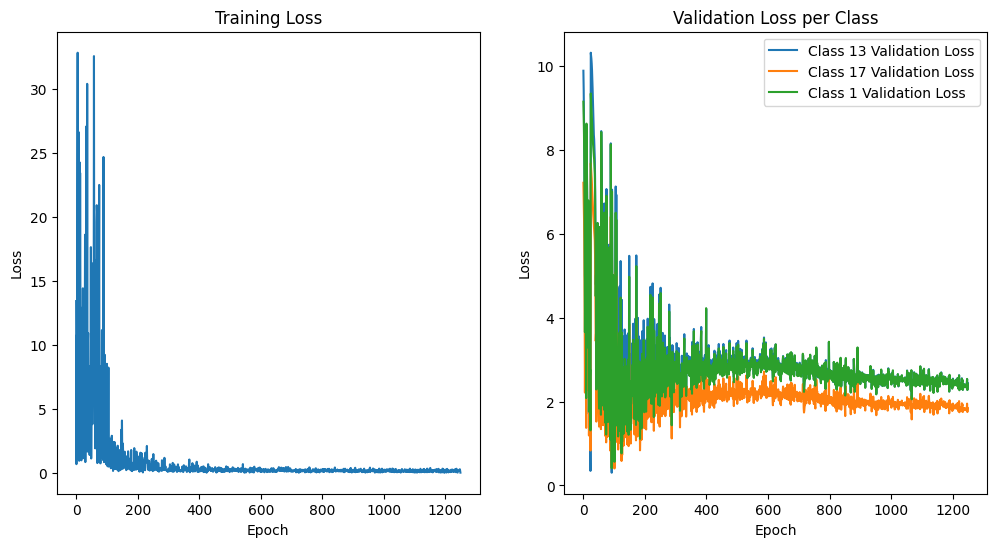

Validation Loss: 2.2337
~~~~~~~~~~~~~~~~~~~~~~~~~~
Start of TRAINING
Number of parameters: 3713
Number of Epochs 1250
No Learning Rate Decay


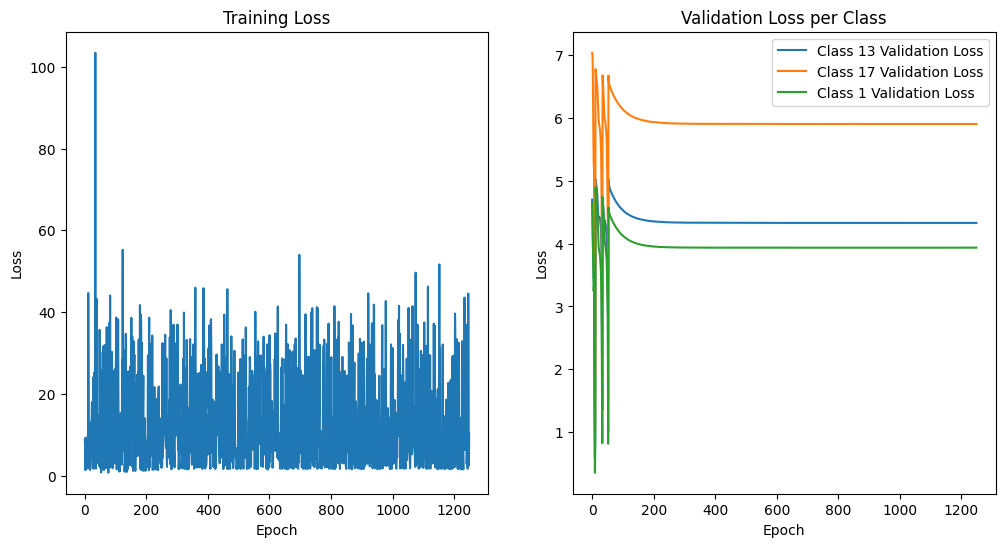

Validation Loss: 4.7235
~~~~~~~~~~~~~~~~~~~~~~~~~~
Start of TRAINING
Number of parameters: 3713
Number of Epochs 1250
No Learning Rate Decay


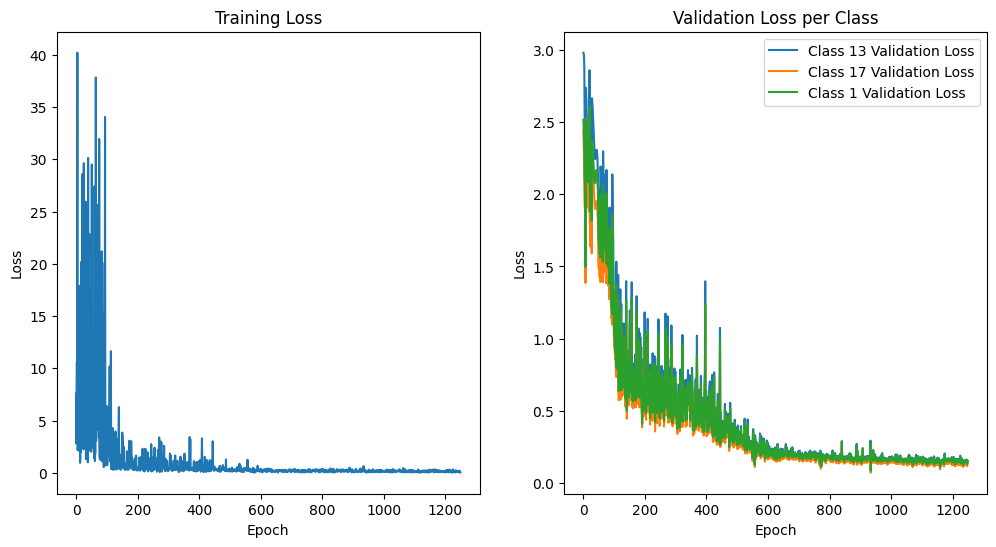

Validation Loss: 0.1474
~~~~~~~~~~~~~~~~~~~~~~~~~~
Start of TRAINING
Number of parameters: 3713
Number of Epochs 1250
No Learning Rate Decay


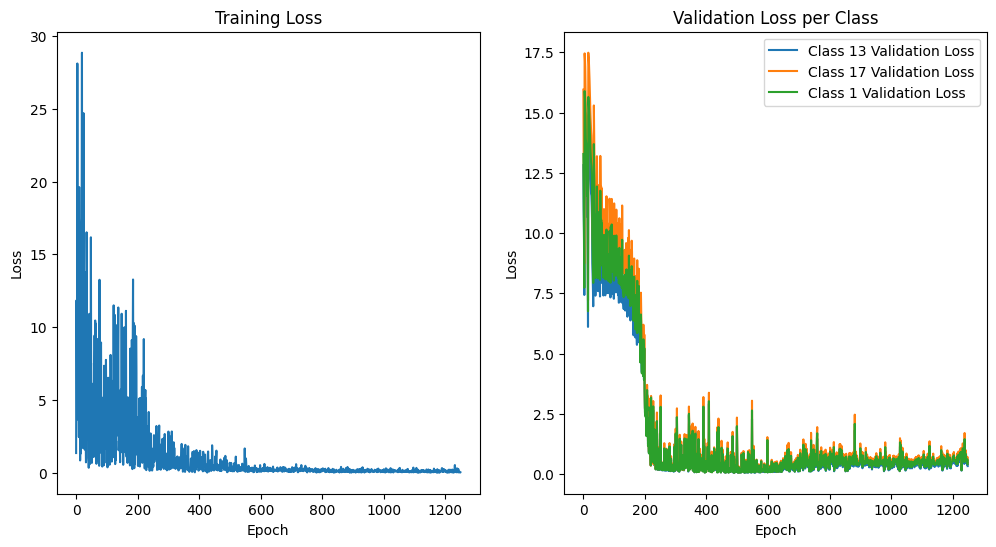

Validation Loss: 0.4058
~~~~~~~~~~~~~~~~~~~~~~~~~~
Start of TRAINING
Number of parameters: 3713
Number of Epochs 1250
No Learning Rate Decay


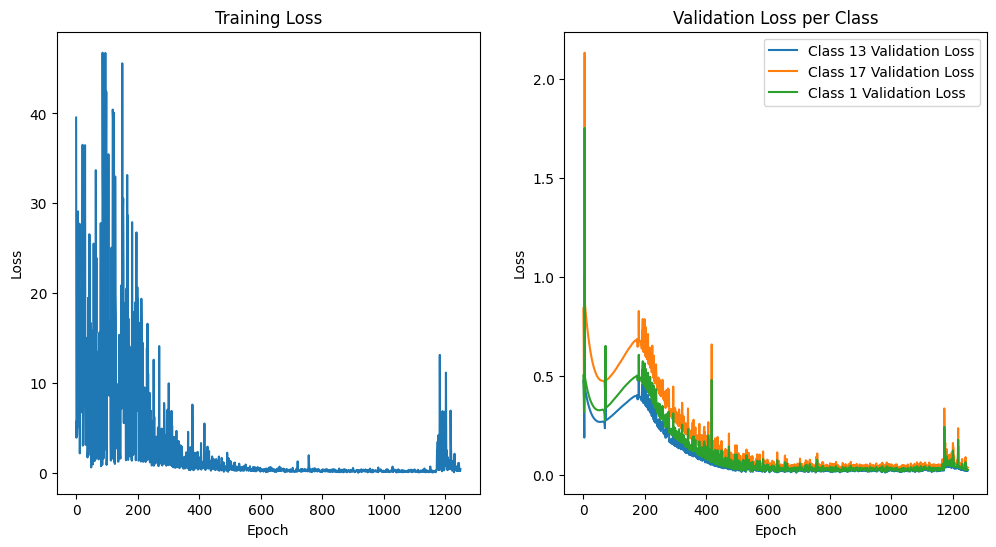

Validation Loss: 0.0270
~~~~~~~~~~~~~~~~~~~~~~~~~~
CPU times: user 2h 30min 26s, sys: 1min 47s, total: 2h 32min 14s
Wall time: 10min 53s


In [13]:
%%time
# Initialise list to store models
models = []

#train 5x
trainNumber = 5

for runs in range(trainNumber):    
    # Define model, loss function, and optimizer
    #Initialize the model
    hidden_size = num_channels[len(num_channels)-1]
    output_size = targets.shape[1]  # Predicting overall number of fish
    num_chanellsOut = num_channels[len(num_channels)-1]
    
    model = FishCountPredictor(input_size, hidden_size, output_size, num_chanellsOut)
    
    #Get number of params 
    total_params = sum(p.numel() for p in model.parameters())
    print("Start of TRAINING")
    print(f"Number of parameters: {total_params}")
    
    # Initialise list to store validation losses for each fold
    validation_losses = []
    
    #Define batch_size
    batchSize = 64
    
    #Use the bins to stratify the split
    val_split=0.1
    
    train_indices, val_indices = train_test_split(
        np.arange(binsOverall.shape[0]),
        test_size=val_split,
        stratify=binsOverall
    )
    
    train_data = Subset(dataset, indices=train_indices)
    val_data = Subset(dataset, indices=val_indices)
        
    train_dataloader = DataLoader(train_data, batch_size=batchSize, shuffle=True) #shuffle the train dataloader!
    
    val_dataloader = DataLoader(val_data, batch_size=batchSize, shuffle=False)
    
    num_epochs = 250*round(len(train_data)/batchSize)
    epoch_delay = num_epochs+1 # *0.n to give percentage, +1 to not include a decay
    
    print('Number of Epochs ' + str(num_epochs))
    
    if epoch_delay < num_epochs:
        print('Learning Rate Decay @ Epoch ' + str(epoch_delay))
    else:
        print('No Learning Rate Decay')
    
    #Initialise the model
    model = FishCountPredictor(input_size, hidden_size, output_size, num_chanellsOut)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    lr_after_decay = 0.001
    
    train_model(model, train_dataloader, optimizer, lr_after_decay, epoch_delay, num_epochs, dataloaderVal = val_dataloader)
    
    lossList = []
    val_loss = evaluate_model(model, val_dataloader)
    #validation_losses.append(val_loss)
    validation_losses.append(sum(val_loss) / len(val_loss))
    
    # Store model
    model_state = deepcopy(model.state_dict())
    models.append(model_state)
    
    # Calculate validation
    avg_val_loss = sum(validation_losses)
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~')

count = 0

for model_states in models:
    num_chanellsOut = num_channels[len(num_channels)-1]
    hidden_size = num_channels[len(num_channels)-1]
    #del evalModel
    evalModel = FishCountPredictor(input_size, hidden_size, output_size, num_chanellsOut)
    
    #Change the model here
    #evalModel.load_state_dict(torch.load('/mnt/Internal/01_PhD/19_biomass_estimation_with_AI/Nmax_improvement/01_Models/j02072024_471013_1000'))
    model_state = deepcopy(model_states)
    evalModel.load_state_dict(model_state)

    torch.save(evalModel.state_dict(), './06_Models/model_number_' + str(count))
    count = count + 1

Mean Absolute Error   =  0.43274853
Absolute Error =  74.0
Number of parameters: 3713
Overall Pearson R,all =  0.9862784317467482
Overall Pearson R,wo0 =  0.9830815379773501
Overall Pearson R,wo01 =  0.9807152436277841
Overall Mean Absolute Error =  0.43274853


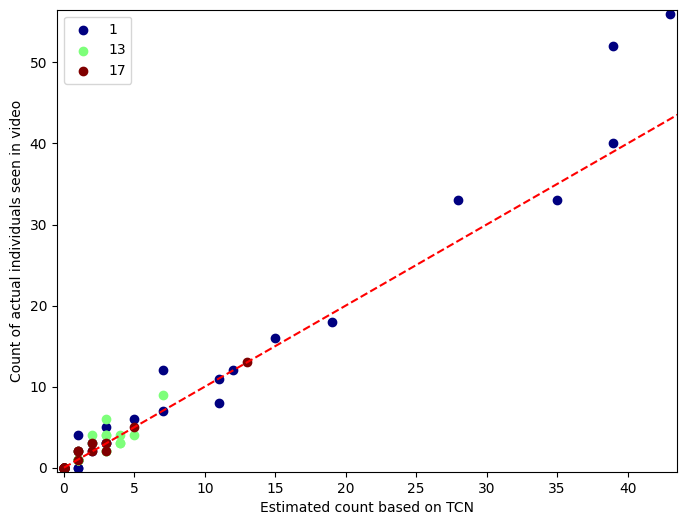

In [40]:
### TO SAVE THE MODEL AND THE RESULTS ON TEST!
#Initialize the model
evalModel = FishCountPredictor(input_size, hidden_size, output_size, num_chanellsOut)

#If model is still in memory

model_state = deepcopy(model.state_dict())
evalModel.load_state_dict(model_state)

#If model is saved in a dir

#evalModel.load_state_dict(torch.load(
#'Direcotry_to_Model'
#))

evalModel.eval()

total_loss = 0.0

sumDiff = 0

with torch.no_grad():        
    # Multi sample example
    testSequence = sequences_Test.reshape(sequences_Test.shape[0],1,sequences_Test.shape[1])
    testTargets = targets_Test

    species_ID = dataset_Test.iloc[:, 5:6]
    species_ID = torch.tensor(species_ID['species_id'].values)
    
    output = evalModel(testSequence)
    output = torch.round(output)
    output = torch.abs(output)
    output = output.squeeze()
    #print(output)

    # Do the multi head output with a mask for the species not involved and use only the species needed
    mask_s0 = (species_ID == 13)
    mask_s1 = (species_ID == 17)
    mask_s2 = (species_ID == 1)
    
    mask_s0 = mask_s0.long()
    mask_s1 = mask_s1.long()
    mask_s2 = mask_s2.long()
 
    output = mask_s0*output[:,0] + mask_s1*output[:,1] + mask_s2*output[:,2]

    testTarget = testTargets[:,0] + testTargets[:,1] + testTargets[:,2]
    
videoNames = dataset_Test['videoname']
videoNames = videoNames.to_numpy()

trueValues = pd.DataFrame(testTarget.numpy())
dataset_testVideonames = pd.DataFrame(videoNames)
predictions = pd.DataFrame(output.numpy())
species_ID = pd.DataFrame(species_ID.numpy())

finalTest = pd.concat([dataset_testVideonames, trueValues], axis=1)
finalTest = pd.concat([finalTest, predictions], axis=1)
finalTest = pd.concat([finalTest, species_ID], axis=1)

finalTest = finalTest.set_axis(['videoname', 'trueValue', 'Ntcn', 'species_ID'], axis=1)

mae = mean_absolute_error(trueValues.squeeze(), predictions.squeeze())
print('Mean Absolute Error ', ' = ', mae)

ae = sum(abs(trueValues.squeeze() - predictions.squeeze()))
print('Absolute Error = ', ae)

overallKfoldTests = pd.concat([finalTest])
    
total_params = sum(p.numel() for p in evalModel.parameters()) 
print(f"Number of parameters: {total_params}")

# Assign unique colors to each species_ID
species = overallKfoldTests['species_ID'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(species)))
color_map = dict(zip(species, colors))

# Color each point based on species_ID
plt.figure(figsize=(8, 6))
for species in color_map:
    subset = finalTest[finalTest['species_ID'] == species]
    plt.scatter(subset['Ntcn'], subset['trueValue'], color=color_map[species], label=species)
plt.plot([0, 100], [0, 100], color='red', linestyle='dashed')
plt.xlim(-0.5, 0.5 + max(finalTest['Ntcn']))
plt.ylim(-0.5, 0.5 + max(finalTest['trueValue']))
plt.xlabel('Estimated count based on TCN')
plt.ylabel('Count of actual individuals seen in video')
plt.legend()

corr, _ = pearsonr(finalTest['trueValue'], finalTest['Ntcn']) 
print('Overall Pearson R,all = ' , corr)

trueValue = finalTest['trueValue'] 
Ntcn = finalTest['Ntcn']

#Step 1: Remove entries where trueValue is 0

filtered_trueValue_zeros = [tv for tv in trueValue if tv != 0] 
filtered_Ntcn_zeros = [nt for tv, nt in zip(trueValue, Ntcn) if tv != 0]

#Calculate correlation without 0s in trueValue

correlation_no_zeros = pearsonr(filtered_trueValue_zeros, filtered_Ntcn_zeros)[0] 
print("Overall Pearson R,wo0 = ", correlation_no_zeros)

#Step 2: Remove entries where trueValue is 0 or 1

filtered_trueValue_zeros_ones = [tv for tv in trueValue if tv not in [0, 1]] 
filtered_Ntcn_zeros_ones = [nt for tv, nt in zip(trueValue, Ntcn) if tv not in [0, 1]]

#Calculate correlation without 0s and 1s in trueValue

correlation_no_zeros_ones = pearsonr(filtered_trueValue_zeros_ones, filtered_Ntcn_zeros_ones)[0] 
print("Overall Pearson R,wo01 = ", correlation_no_zeros_ones)

mae = mean_absolute_error(trueValues, Ntcn) 
print('Overall Mean Absolute Error = ', mae)

#Uncomment to save the model
#torch.save(evalModel.state_dict(), '/mnt/Internal/01_PhD/19_biomass_estimation_with_AI/Nmax_improvement/01_Models/my_checkpoint')

#Uncomment to save the counts
#finalTest.to_csv('./05_Results/allClass_Ntcn_onTestLabels.csv', sep=',', index=False, encoding='utf-8')  

Number of parameters: 3713
Overall Pearson R,all =  0.990569312342257
Overall Pearson R,wo0 =  0.9848050654445006
Overall Pearson R,wo01 =  0.984306074089043
Overall Mean Absolute Error =  0.07272727
Overall Absolute Error =  4


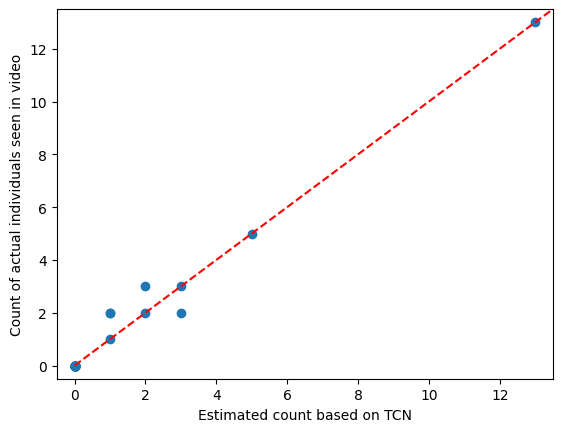

In [64]:
### Species 17 - SCIAENA UMBRA 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define the data
dataset_Test_SU = pd.read_csv('./04_Datasets/dataset_17/boundingboxes_class17.csv')
dataset_Test_SU.fillna(0, inplace=True)
#dataset_Train = dataset[dataset["category"] == 'train']
dataset_Test_SU = dataset_Test_SU[dataset_Test_SU["category"] == 'test']

#Define the SU set
sequences = dataset_Test_SU.iloc[:, 3:].values.tolist() # List of sequences of fish counts
testTargets = dataset_Test_SU.iloc[:, 2].values.tolist()   # List of corresponding overall number of fish

sequences = torch.tensor(sequences, dtype=torch.float32)
testTargets = torch.tensor(testTargets, dtype=torch.float32)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Load the model
model_state = deepcopy(model.state_dict())
evalModel.load_state_dict(model_state)

#If model is saved in a dir

#evalModel.load_state_dict(torch.load(
#'Direcotry_to_Model'
#))

evalModel.eval()

evalModel.eval()

total_loss = 0.0

sumDiff = 0

with torch.no_grad():
    # Multi sample example
    testSequence = sequences.reshape(sequences.shape[0],1,sequences.shape[1])
    
    output = evalModel(testSequence)    
    output = torch.round(output)
    output = torch.abs(output)
    output = output.squeeze()

total_params = sum(p.numel() for p in evalModel.parameters())
print(f"Number of parameters: {total_params}")

videoNames = dataset_Test_SU['videoname']
videoNames = videoNames.to_numpy()

trueValues = pd.DataFrame(testTargets.numpy())
dataset_testVideonames = pd.DataFrame(videoNames)
predictions = pd.DataFrame(output.detach().numpy())
predictions = predictions[1]

finalTest = pd.concat([dataset_testVideonames, trueValues], axis=1)
finalTest = pd.concat([finalTest, predictions], axis=1)

finalTest = finalTest.set_axis(['videoname', 'trueValue', 'Ntcn'], axis=1)

plt.scatter(predictions, trueValues)
# set axes range
plt.xlim(-0.5, 0.5+max(predictions)) 
plt.ylim(-0.5, 0.5+max(testTargets)) 
plt.xlabel('Estimated count based on TCN') 
plt.ylabel('Count of actual individuals seen in video') 
plt.plot([0, 100], [0, 100], color='red', linestyle='dashed')

Ntcn = output[:,1]
trueValues = testTargets

#Get the metrics
corr, _ = pearsonr(trueValues, Ntcn) 
print('Overall Pearson R,all = ' , corr)

#Step 1: Remove entries where trueValue is 0

filtered_trueValue_zeros = [tv for tv in trueValues if tv != 0] 
filtered_Ntcn_zeros = [nt for tv, nt in zip(trueValues, Ntcn) if tv != 0]

#Calculate correlation without 0s in trueValue

correlation_no_zeros = pearsonr(filtered_trueValue_zeros, filtered_Ntcn_zeros)[0] 
print("Overall Pearson R,wo0 = ", correlation_no_zeros)

#Step 2: Remove entries where trueValue is 0 or 1

filtered_trueValue_zeros_ones = [tv for tv in trueValues if tv not in [0, 1]] 
filtered_Ntcn_zeros_ones = [nt for tv, nt in zip(trueValues, Ntcn) if tv not in [0, 1]]

#Calculate correlation without 0s and 1s in trueValue

correlation_no_zeros_ones = pearsonr(filtered_trueValue_zeros_ones, filtered_Ntcn_zeros_ones)[0] 
print("Overall Pearson R,wo01 = ", correlation_no_zeros_ones)

mae = mean_absolute_error(trueValues, Ntcn) 
print('Overall Mean Absolute Error = ', mae)

ae = sum(abs(trueValues - Ntcn))
print('Overall Absolute Error = ', int(ae))

#Save the CSV
#finalTest.to_csv('./05_Results/class_17_Ntcn_onTestLabels.csv', sep=',', index=False, encoding='utf-8')         

Number of parameters: 3713
Overall Pearson R,all =  0.9318054655496274
Overall Pearson R,wo0 =  0.8289199011412834
Overall Pearson R,wo01 =  0.6910555827876079
Overall Mean Absolute Error =  0.29090908
Overall Absolute Error =  16


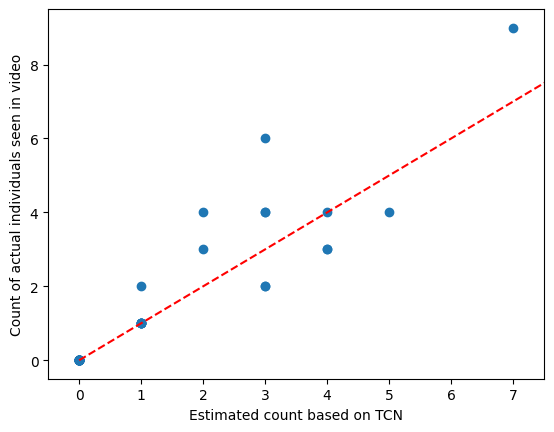

In [63]:
# CLASS 13 - EPINEPHELUS MARGINATUS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define the data
dataset_Test_EM = pd.read_csv('./04_Datasets/dataset_13/boundingboxes_class13.csv')
dataset_Test_EM.fillna(0, inplace=True)
#dataset_Train = dataset[dataset["category"] == 'train']
dataset_Test_EM = dataset_Test_EM[dataset_Test_EM["category"] == 'test']

#Define the SU set
sequences = dataset_Test_EM.iloc[:, 3:].values.tolist() # List of sequences of fish counts
testTargets = dataset_Test_EM.iloc[:, 2].values.tolist()   # List of corresponding overall number of fish

sequences = torch.tensor(sequences, dtype=torch.float32)
testTargets = torch.tensor(testTargets, dtype=torch.float32)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Load the model
model_state = deepcopy(model.state_dict())
evalModel.load_state_dict(model_state)

#If model is saved in a dir

#evalModel.load_state_dict(torch.load(
#'Direcotry_to_Model'
#))

evalModel.eval()

evalModel.eval()

total_loss = 0.0

sumDiff = 0

with torch.no_grad():
    # Multi sample example
    testSequence = sequences.reshape(sequences.shape[0],1,sequences.shape[1])
    
    output = evalModel(testSequence)    
    output = torch.round(output)
    output = torch.abs(output)
    output = output.squeeze()

total_params = sum(p.numel() for p in evalModel.parameters())
print(f"Number of parameters: {total_params}")

videoNames = dataset_Test_EM['videoname']
videoNames = videoNames.to_numpy()

trueValues = pd.DataFrame(testTargets.numpy())
dataset_testVideonames = pd.DataFrame(videoNames)
predictions = pd.DataFrame(output.detach().numpy())
predictions = predictions[1]

finalTest = pd.concat([dataset_testVideonames, trueValues], axis=1)
finalTest = pd.concat([finalTest, predictions], axis=1)

finalTest = finalTest.set_axis(['videoname', 'trueValue', 'Ntcn'], axis=1)

plt.scatter(predictions, trueValues)
# set axes range
plt.xlim(-0.5, 0.5+max(predictions)) 
plt.ylim(-0.5, 0.5+max(testTargets)) 
plt.xlabel('Estimated count based on TCN') 
plt.ylabel('Count of actual individuals seen in video') 
plt.plot([0, 100], [0, 100], color='red', linestyle='dashed')

Ntcn = output[:,1]
trueValues = testTargets

#Get the metrics
corr, _ = pearsonr(trueValues, Ntcn) 
print('Overall Pearson R,all = ' , corr)

#Step 1: Remove entries where trueValue is 0

filtered_trueValue_zeros = [tv for tv in trueValues if tv != 0] 
filtered_Ntcn_zeros = [nt for tv, nt in zip(trueValues, Ntcn) if tv != 0]

#Calculate correlation without 0s in trueValue

correlation_no_zeros = pearsonr(filtered_trueValue_zeros, filtered_Ntcn_zeros)[0] 
print("Overall Pearson R,wo0 = ", correlation_no_zeros)

#Step 2: Remove entries where trueValue is 0 or 1

filtered_trueValue_zeros_ones = [tv for tv in trueValues if tv not in [0, 1]] 
filtered_Ntcn_zeros_ones = [nt for tv, nt in zip(trueValues, Ntcn) if tv not in [0, 1]]

#Calculate correlation without 0s and 1s in trueValue

correlation_no_zeros_ones = pearsonr(filtered_trueValue_zeros_ones, filtered_Ntcn_zeros_ones)[0] 
print("Overall Pearson R,wo01 = ", correlation_no_zeros_ones)

mae = mean_absolute_error(trueValues, Ntcn) 
print('Overall Mean Absolute Error = ', mae)

ae = sum(abs(trueValues - Ntcn))
print('Overall Absolute Error = ', int(ae))

#Save the CSV
#finalTest.to_csv('./05_Results/class_13_Ntcn_onTestLabels.csv', sep=',', index=False, encoding='utf-8')   

Number of parameters: 3713
Overall Pearson R,all =  0.9860812438472488
Overall Pearson R,wo0 =  0.9821067640467078
Overall Pearson R,wo01 =  0.9777230300450794
Overall Pearson R,wo010 =  0.9600895278210583
Overall Mean Absolute Error =  0.94545454
Overall Absolute Error =  52


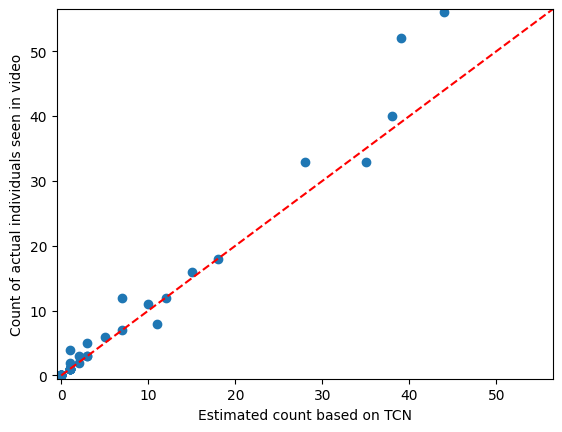

In [62]:
### DIPLODUS VULGARIS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define the data
dataset_Test_DV = pd.read_csv('./04_Datasets/dataset_1/boundingboxes_class1.csv')
dataset_Test_DV.fillna(0, inplace=True)
#dataset_Train = dataset[dataset["category"] == 'train']
dataset_Test_DV = dataset_Test_DV[dataset_Test_DV["category"] == 'test']

#Define the SU set
sequences = dataset_Test_DV.iloc[:, 3:].values.tolist() # List of sequences of fish counts
testTargets = dataset_Test_DV.iloc[:, 2].values.tolist()   # List of corresponding overall number of fish

sequences = torch.tensor(sequences, dtype=torch.float32)
testTargets = torch.tensor(testTargets, dtype=torch.float32)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Load the model
model_state = deepcopy(model.state_dict())
evalModel.load_state_dict(model_state)

#If model is saved in a dir

#evalModel.load_state_dict(torch.load(
#'Direcotry_to_Model'
#))

evalModel.eval()

evalModel.eval()

total_loss = 0.0

sumDiff = 0

with torch.no_grad():
    # Multi sample example
    testSequence = sequences.reshape(sequences.shape[0],1,sequences.shape[1])
    
    output = evalModel(testSequence)    
    output = torch.round(output)
    output = torch.abs(output)
    output = output.squeeze()

total_params = sum(p.numel() for p in evalModel.parameters())
print(f"Number of parameters: {total_params}")

videoNames = dataset_Test_DV['videoname']
videoNames = videoNames.to_numpy()

trueValues = pd.DataFrame(testTargets.numpy())
dataset_testVideonames = pd.DataFrame(videoNames)
predictions = pd.DataFrame(output.detach().numpy())
predictions = predictions[1]

finalTest = pd.concat([dataset_testVideonames, trueValues], axis=1)
finalTest = pd.concat([finalTest, predictions], axis=1)

finalTest = finalTest.set_axis(['videoname', 'trueValue', 'Ntcn'], axis=1)

plt.scatter(predictions, trueValues)
# set axes range
plt.xlim(-0.5, 0.5+max(predictions)) 
plt.ylim(-0.5, 0.5+max(testTargets)) 
plt.xlabel('Estimated count based on TCN') 
plt.ylabel('Count of actual individuals seen in video') 
plt.plot([0, 100], [0, 100], color='red', linestyle='dashed')

Ntcn = output[:,1]
trueValues = testTargets

#Get the metrics
corr, _ = pearsonr(trueValues, Ntcn) 
print('Overall Pearson R,all = ' , corr)

#Step 1: Remove entries where trueValue is 0

filtered_trueValue_zeros = [tv for tv in trueValues if tv != 0] 
filtered_Ntcn_zeros = [nt for tv, nt in zip(trueValues, Ntcn) if tv != 0]

#Calculate correlation without 0s in trueValue

correlation_no_zeros = pearsonr(filtered_trueValue_zeros, filtered_Ntcn_zeros)[0] 
print("Overall Pearson R,wo0 = ", correlation_no_zeros)

#Step 2: Remove entries where trueValue is 0 or 1

filtered_trueValue_zeros_ones = [tv for tv in trueValues if tv not in [0, 1]] 
filtered_Ntcn_zeros_ones = [nt for tv, nt in zip(trueValues, Ntcn) if tv not in [0, 1]]

#Calculate correlation without 0s and 1s in trueValue

correlation_no_zeros_ones = pearsonr(filtered_trueValue_zeros_ones, filtered_Ntcn_zeros_ones)[0] 
print("Overall Pearson R,wo01 = ", correlation_no_zeros_ones)

mae = mean_absolute_error(trueValues, Ntcn) 
print('Overall Mean Absolute Error = ', mae)

ae = sum(abs(trueValues - Ntcn))
print('Overall Absolute Error = ', int(ae))

#Save the CSV
#finalTest.to_csv('./05_Results/class_1_Ntcn_onTestLabels.csv', sep=',', index=False, encoding='utf-8')   